<h1 align="center"> Spatial Analysis of Airbnb listings in NYC</h1>

 <h2> Before we Begin: </h2> 
 To reproduce this work, you will need to the following datases from the NYC Open Data site:<br>
 1.   https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq<br>
 2.   https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49 <br><br>
 **This project also takes advantage of GeoPandas for spatial analysis/plotting of maps: http://geopandas.org/** <br><br>
 
 <h2> Introduction </h2>In this kernel I explore the NYC Airbnb listings dataset in a spatial context. I also conduct an analysis to find a listing that meets specific criteria for an upcoming trip where I theoretically attend a New York Yankees baseball game.
 
 <br><br><br>
 <h2> Outline: </h2>
 
 I. <b> Understanding our data</b> <br>
 a) [Explore Data](#explore)<br>
 
 II. <b> Borough/Neighborhood Charts and Maps</b> <br>
 a) [Borough Plots](#cbbmap)<br>
 b) [Neighborhood Map](#nbmap)<br>
 c) [Fixed Neighborhood Map](#rnbmap)<br>
 
 III. <b> Yankee Stadium Analysis</b><br>
 a) [Criteria](#yankeestadium)<br>
 b) [Mapping Yankee Stadium](#yankeesmap)<br>
 c) [Subway Analysis](#subways)<br>
 d) [Criteria Analysis](#criteria)<br>
 e) [Airbnb's near Subways](#abnearsubways)<br>
 
 IV. <b> Final Results! </b> <br>
 a) [Airbnbs that meet all criteria](#finalresults)<br>


In [35]:
#Import various python packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely import wkt

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

plt.style.use('fivethirtyeight')

../input/train.csv
../input/test.csv
../input/googleplaystore.csv
../input/googleplaystore_user_reviews.csv
../input/data.csv
../input/nbhoods/nynta.csv
../input/new-york-city-airbnb-open-data/AB_NYC_2019.csv
../input/nyc-subway-stations/DOITT_SUBWAY_STATION_01_13SEPT2010.csv


# Understanding our Data
 <a id="explore"></a>First we will bring in the data, look at its structure, data types, and do make some simple plots

In [36]:
#Create a pandas dataframe of the Airbnb data
data = pd.read_csv('../input/new-york-city-airbnb-open-data/AB_NYC_2019.csv')

data.head(5)

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [37]:
#Review the data types
data.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [38]:
#Review the columns 
data.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [39]:
#Rename a column to accurately reflect Boroughs
data.rename(columns={'neighbourhood_group':'boroname'}, inplace=True)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

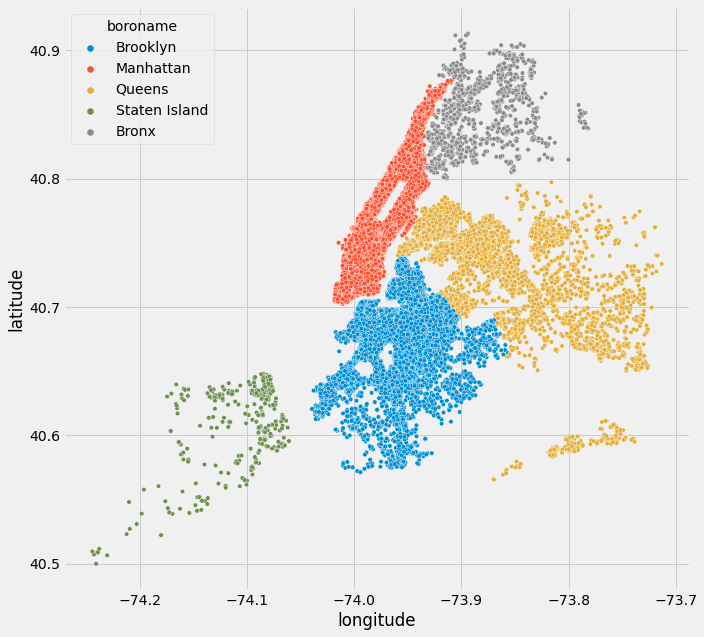

In [40]:
#Review the listings by boroname
plt.figure(figsize=(10,10))
sns.scatterplot(x='longitude', y='latitude', hue='boroname',s=20, data=data)

# Borough/Neighborhood Charts & Maps:
 <a id="cbbmap"></a>
### Lets do an aggregation by borough, look at a bar chart, then use geopandas to read in a basemap

In [41]:
#Get a count by borough
borough_count = data.groupby('boroname').agg('count').reset_index()

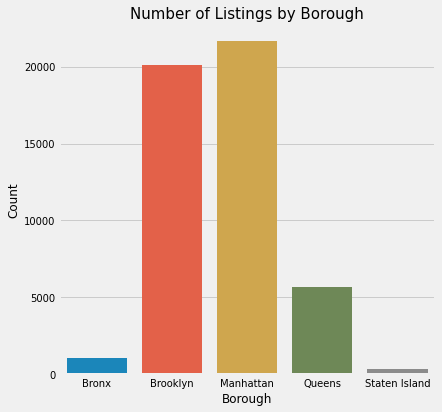

In [42]:
#Plot the count by borough
fig, ax1 = plt.subplots(1,1, figsize=(6,6)
                       )
sns.barplot(x='boroname', y='id', data=borough_count, ax=ax1)

ax1.set_title('Number of Listings by Borough', fontsize=15)
ax1.set_xlabel('Borough', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.tick_params(axis='both', labelsize=10)

In [43]:
#Here we are using geopandas to bring in a base layer of NYC boroughs
nyc = gpd.read_file(gpd.datasets.get_path('nybb'))
nyc.head(5)

BoroCode       BoroName     Shape_Leng    Shape_Area  \
0         5  Staten Island  330470.010332  1.623820e+09   
1         4         Queens  896344.047763  3.045213e+09   
2         3       Brooklyn  741080.523166  1.937479e+09   
3         1      Manhattan  359299.096471  6.364715e+08   
4         2          Bronx  464392.991824  1.186925e+09   

                                            geometry  
0  MULTIPOLYGON (((970217.022 145643.332, 970227....  
1  MULTIPOLYGON (((1029606.077 156073.814, 102957...  
2  MULTIPOLYGON (((1021176.479 151374.797, 102100...  
3  MULTIPOLYGON (((981219.056 188655.316, 980940....  
4  MULTIPOLYGON (((1012821.806 229228.265, 101278...

In [44]:
#Rename the column to boroname, so that we can join the data to it on a common field
nyc.rename(columns={'BoroName':'boroname'}, inplace=True)
bc_geo = nyc.merge(borough_count, on='boroname')

<ipython-input-45-7e9fde5d080d>:4: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  bc_geo.apply(lambda x: ax.annotate(s=x.boroname, color='black', xy=x.geometry.centroid.coords[0],ha='center'), axis=1)


(905464.739038086, 1075092.8783935548, 112485.76063504723, 280480.41425942676)

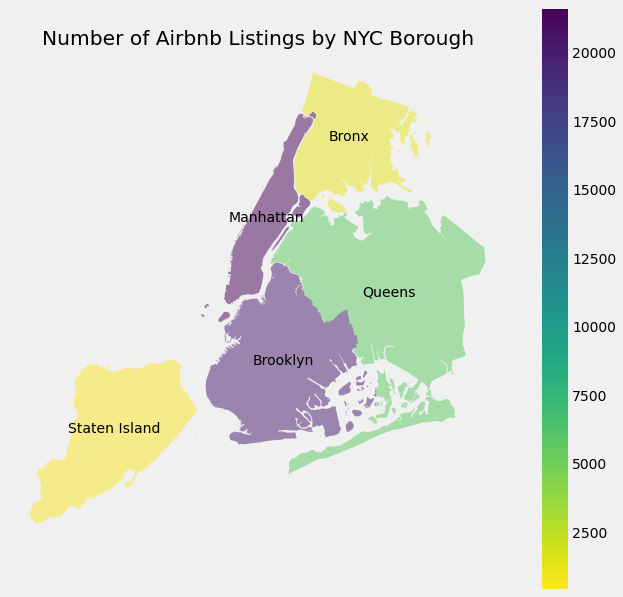

In [45]:
#Plot the count by borough into a map
fig,ax = plt.subplots(1,1, figsize=(10,10))
bc_geo.plot(column='id', cmap='viridis_r', alpha=.5, ax=ax, legend=True)
bc_geo.apply(lambda x: ax.annotate(s=x.boroname, color='black', xy=x.geometry.centroid.coords[0],ha='center'), axis=1)
plt.title("Number of Airbnb Listings by NYC Borough")
plt.axis('off')

### Lets explore neighborhoods:
 <a id="nbmap"></a>
### We do not have the geometries of neighborhoods, so lets bring in a CSV file from the NYC Open Data Site. It has wkt in a geometry column. 
### We can convert that to a GeoPandas Data Frame

In [46]:
#Now,lets take a look at the count by neighborhood. Use the file downloaded from https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq
nbhoods = pd.read_csv('../input/nbhoods/nynta.csv')
nbhoods.head(5)

the_geom  CountyFIPS  BoroCode  \
0  MULTIPOLYGON (((-73.97604935657381 40.63127590...          47         3   
1  MULTIPOLYGON (((-73.80379022888246 40.77561011...          81         4   
2  MULTIPOLYGON (((-73.8610972440186 40.763664477...          81         4   
3  MULTIPOLYGON (((-73.75725671443085 40.71813860...          81         4   
4  MULTIPOLYGON (((-73.95859278495766 40.61040303...          47         3   

   BoroName NTACode        NTAName    Shape_Leng    Shape_Area  
0  Brooklyn    BK88   Borough Park  39247.227831  5.400502e+07  
1    Queens    QN51    Murray Hill  33266.904872  5.248828e+07  
2    Queens    QN27  East Elmhurst  19816.712132  1.972685e+07  
3    Queens    QN07         Hollis  20976.335781  2.288777e+07  
4  Brooklyn    BK25      Homecrest  27514.022918  2.999197e+07

In [47]:
#There is a lot going on here... first rename the column
nbhoods.rename(columns={'NTAName':'neighbourhood'}, inplace=True)

#Then, since this is a csv file, convert the geometry column text into well known text, this will allow you to plot its geometry correctly
nbhoods['geom'] = nbhoods['the_geom'].apply(wkt.loads)

#Now convert the pandas dataframe into a Geopandas GeoDataFrame
nbhoods = gpd.GeoDataFrame(nbhoods, geometry='geom')

<AxesSubplot:>

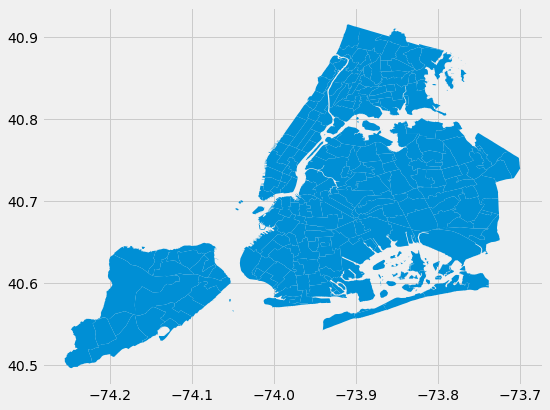

In [48]:

#Lets take a look at what the neighborhoods look like
fig,ax = plt.subplots(1,1, figsize=(8,8))
nbhoods.plot(ax=ax)

In [49]:
#Lets get a count by neighborhood
nbhood_count = data.groupby('neighbourhood').agg('count').reset_index()

In [50]:
#Lets merge the spatial GeoPandas Dataframe (with geometry), with the nbhood_count layer that is aggregated
nb_count_geo = nbhoods.merge(nbhood_count, on='neighbourhood')
nb_count_geo.head(3)

the_geom  CountyFIPS  BoroCode  \
0  MULTIPOLYGON (((-73.97604935657381 40.63127590...          47         3   
1  MULTIPOLYGON (((-73.80379022888246 40.77561011...          81         4   
2  MULTIPOLYGON (((-73.8610972440186 40.763664477...          81         4   

   BoroName NTACode  neighbourhood    Shape_Leng    Shape_Area  \
0  Brooklyn    BK88   Borough Park  39247.227831  5.400502e+07   
1    Queens    QN51    Murray Hill  33266.904872  5.248828e+07   
2    Queens    QN27  East Elmhurst  19816.712132  1.972685e+07   

                                                geom   id  ...  latitude  \
0  MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...  136  ...       136   
1  MULTIPOLYGON (((-73.80379 40.77561, -73.80099 ...  485  ...       485   
2  MULTIPOLYGON (((-73.86110 40.76366, -73.85993 ...  185  ...       185   

   longitude  room_type  price  minimum_nights  number_of_reviews  \
0        136        136    136             136                136   
1        485        485    485             485                485   
2        185        185    185             185                185   

   last_review  reviews_per_month  calculated_host_listings_count  \
0          110                110                             136   
1          311                311                             485   
2          171                171                             185   

   availability_365  
0               136  
1               485  
2               185  

[3 rows x 24 columns]

(-74.28337047814922, -73.67222994821337, 40.47514452609842, 40.936503646096)

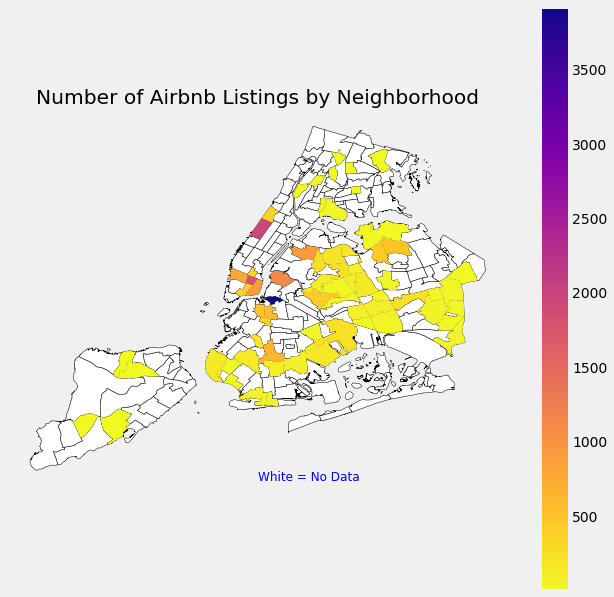

In [51]:
#Lets take a look at the count by neighborhood
fig,ax = plt.subplots(1,1, figsize=(10,10))

base = nbhoods.plot(color='white', edgecolor='black', ax=ax)

nb_count_geo.plot(column='id', cmap='plasma_r', ax=base, legend=True)

plt.title("Number of Airbnb Listings by Neighborhood")
ax.text(0.5, 0.01,'White = No Data',
       verticalalignment='bottom', horizontalalignment='left',
       transform=ax.transAxes,
       color='blue', fontsize=12)
plt.axis('off')

### WOAH! See a problem? This is no bueno.
### Why are there so many areas with missing data?
### My guess is that the neighborhood names do not exactly align**

### The neighborhood names do not exactly align:
# <a id="rnbmap"></a>
# **Lets instead do some spatial operations to find exactly where each Airbnb is located**

In [52]:
#Create a point of each Airbnb location, and enable the "data" dataframe into a geopandas dataframe
data = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))

#Now, do a spatial join... This code here runs an intersect analysis to find which neighborhood the Airbnb location is in
joined = gpd.sjoin(nbhoods, data, how='inner', op='intersects')

In [53]:
#Lets take a look 
joined.head(3)

the_geom  CountyFIPS  BoroCode  \
0  MULTIPOLYGON (((-73.97604935657381 40.63127590...          47         3   
0  MULTIPOLYGON (((-73.97604935657381 40.63127590...          47         3   
0  MULTIPOLYGON (((-73.97604935657381 40.63127590...          47         3   

   BoroName NTACode neighbourhood_left    Shape_Leng    Shape_Area  \
0  Brooklyn    BK88       Borough Park  39247.227831  5.400502e+07   
0  Brooklyn    BK88       Borough Park  39247.227831  5.400502e+07   
0  Brooklyn    BK88       Borough Park  39247.227831  5.400502e+07   

                                                geom  index_right  ...  \
0  MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...        40039  ...   
0  MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...        36156  ...   
0  MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...        36356  ...   

   latitude longitude     room_type price minimum_nights number_of_reviews  \
0  40.63529 -74.00618  Private room    48              1                 2   
0  40.63378 -74.00599  Private room    60              1                 7   
0  40.63416 -74.00722  Private room    50              2                 0   

   last_review  reviews_per_month calculated_host_listings_count  \
0   2019-05-27               0.91                              7   
0   2019-06-04               0.76                              7   
0          NaN                NaN                             10   

   availability_365  
0               169  
0               179  
0               365  

[3 rows x 26 columns]

In [54]:
#Drop the second geometry column
joined.drop(columns='geom', inplace=True)

In [55]:
#Rename the column. 
joined.rename(columns={'neighbourhood_left':'neighbourhood'}, inplace=True)

#Create a count of each neighborhood
nb_join_count = joined.groupby('neighbourhood').agg('count').reset_index()

In [56]:
#Get the "true count". Join this data to the original neighborhoods geometry 
true_count = nbhoods.merge(nb_join_count, on='neighbourhood')

Text(0.5, 1.0, 'Number of Airbnb listings by Neighborhood in NYC')

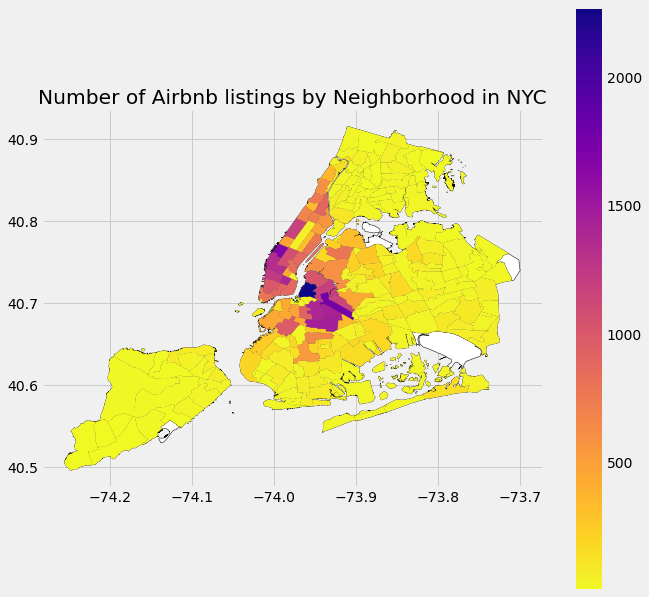

In [57]:
#Lets plot the data
fig,ax = plt.subplots(1,1, figsize=(10,10))

base = nbhoods.plot(color='white', edgecolor='black', ax=ax)

true_count.plot(column='id',cmap='plasma_r', ax=base, legend=True)
plt.title('Number of Airbnb listings by Neighborhood in NYC')

### **BEAUTIFUL! **

### **I now want to do some additional spatial analysis.**
#### **Lets say that I am visiting NYC to go check out a Yankee game. ** <br>
 <a id="yankeestadium"></a>
  **Here are my criteria:**
  <ol>
     <li> I want to stay within 2 miles of the stadium</li>
     <li> I want to stay within 1/4 mile of a subway station that services the D or 4 line</li>
     <li> I want to stay in a place that is less than $250 a night </li>
     <li> The host must have more than 10 reviews</li>
     <li> The minimum night max can not be more than 3 days. We are only coming for an extended weekend</li>
     <li> I want to stay in a place where I can have the entire apartment/home. I have friends coming in</li>
     </ol>


# Yankee Stadium Maps & Analysis:
 <a id="yankeesmap"></a>


In [58]:
#Create a data frame, and add data for Yankee stadium to it
yankee_stadium = pd.DataFrame()
yankee_stadium['name'] = ["Yankee Stadium"]
yankee_stadium['lon'] = -73.926186
yankee_stadium['lat'] = 40.829659
yankee_stadium

name        lon        lat
0  Yankee Stadium -73.926186  40.829659

In [59]:
#Create a geodataframe of Yankee Stadium
yankee_stadium= gpd.GeoDataFrame(yankee_stadium, geometry=gpd.points_from_xy(yankee_stadium.lon, yankee_stadium.lat))

Text(0.5, 1.0, 'Yankee Stadium and NYC')

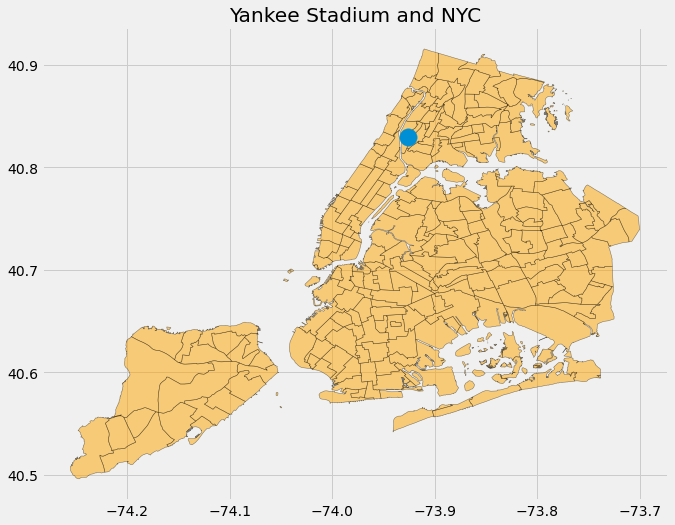

In [60]:
#Lets plot the data
fig,ax1 = plt.subplots(1,1, figsize=(10,10))
base = nbhoods.plot(color='orange',alpha=0.5, edgecolor='black', ax=ax1)
yankee_stadium.plot(markersize=300,ax=base)
plt.title('Yankee Stadium and NYC')

In [61]:
#Lets filter the neighborhoods down to Manahattan and the Bronx
man_bronx_geo = nbhoods.loc[(nbhoods['BoroName'] == 'Manhattan') | (nbhoods['BoroName'] == 'Bronx')]

Text(0.5, 1.0, 'Bronx, Manhattan, and Yankee Stadium')

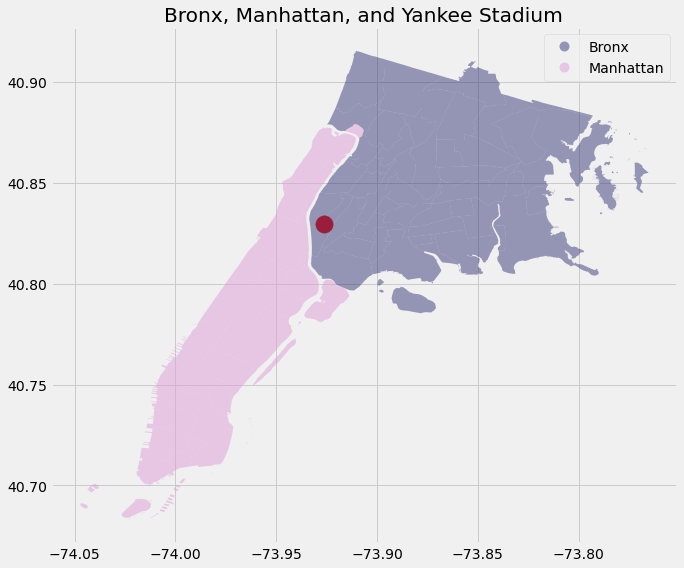

In [62]:
#Plot Yankee Stadium with the Bronx and Manhattan
fig,ax = plt.subplots(1,1, figsize=(10,10))
yankee_stadium.plot(markersize=300,color='red',ax=ax)
man_bronx_geo.plot(column='BoroName', cmap = 'tab20b',alpha=.5, ax=ax, legend=True)
plt.title("Bronx, Manhattan, and Yankee Stadium")

#### Looking at Subways:
 <a id="subways"></a>
Lets add subway data

In [63]:
#Create a pandas dataframe of the Airbnb data
subways = pd.read_csv('../input/nyc-subway-stations/DOITT_SUBWAY_STATION_01_13SEPT2010.csv')
subways.head(5)

URL  OBJECTID              NAME  \
0  http://web.mta.info/nyct/service/         1          Astor Pl   
1  http://web.mta.info/nyct/service/         2          Canal St   
2  http://web.mta.info/nyct/service/         3           50th St   
3  http://web.mta.info/nyct/service/         4         Bergen St   
4  http://web.mta.info/nyct/service/         5  Pennsylvania Ave   

                                       the_geom           LINE  \
0  POINT (-73.99106999861966 40.73005400028978)  4-6-6 Express   
1  POINT (-74.00019299927328 40.71880300107709)  4-6-6 Express   
2  POINT (-73.98384899986625 40.76172799961419)            1-2   
3  POINT (-73.97499915116808 40.68086213682956)          2-3-4   
4  POINT (-73.89488591154061 40.66471445143568)            3-4   

                                               NOTES  
0  4 nights, 6-all times, 6 Express-weekdays AM s...  
1  4 nights, 6-all times, 6 Express-weekdays AM s...  
2                              1-all times, 2-nights  
3           4-nights, 3-all other times, 2-all times  
4                        4-nights, 3-all other times

In [64]:
#Then, since this is a csv file, convert the geometry column text into well known text, this will allow you to plot its geometry correctly
subways['geom'] = subways['the_geom'].apply(wkt.loads)

#Now convert the pandas dataframe into a Geopandas GeoDataFrame
subways = gpd.GeoDataFrame(subways, geometry='geom')

Text(0.5, 1.0, 'NYC Subway Stations and Yankee Stadium')

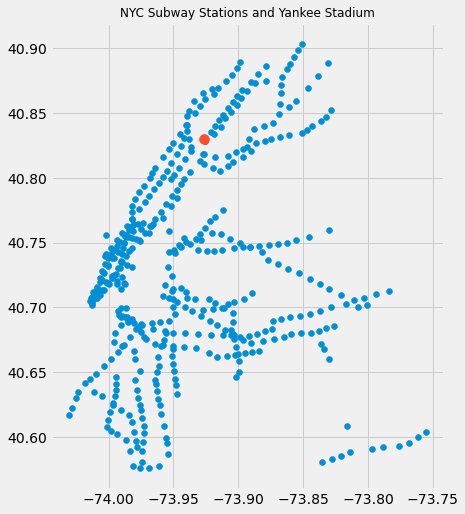

In [65]:
#Lets take a look at what the neighborhoods look like
fig,ax = plt.subplots(1,1, figsize=(8,8))
subways.plot(ax=ax)
yankee_stadium.plot(markersize=100,ax=ax)
plt.title('NYC Subway Stations and Yankee Stadium', fontsize=12)

In [66]:
subways = subways[subways['LINE'].str.contains('4') | (subways['LINE'].str.contains('D'))]

Text(0.5, 1.0, 'NYC Subway Stations Servicing 4 and D lines, with Yankee Stadium')

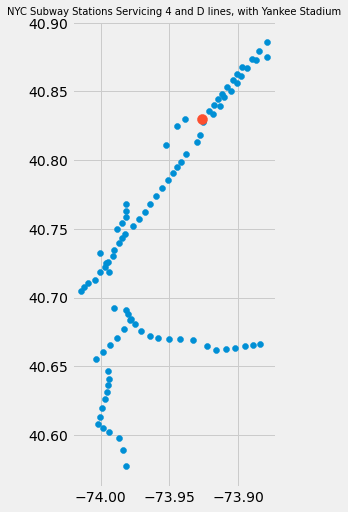

In [67]:
#Lets take a look at what the neighborhoods look like
fig,ax = plt.subplots(1,1, figsize=(8,8))
subways.plot(ax=ax)
yankee_stadium.plot(markersize=100,ax=ax)
plt.title('NYC Subway Stations Servicing 4 and D lines, with Yankee Stadium', fontsize=10)

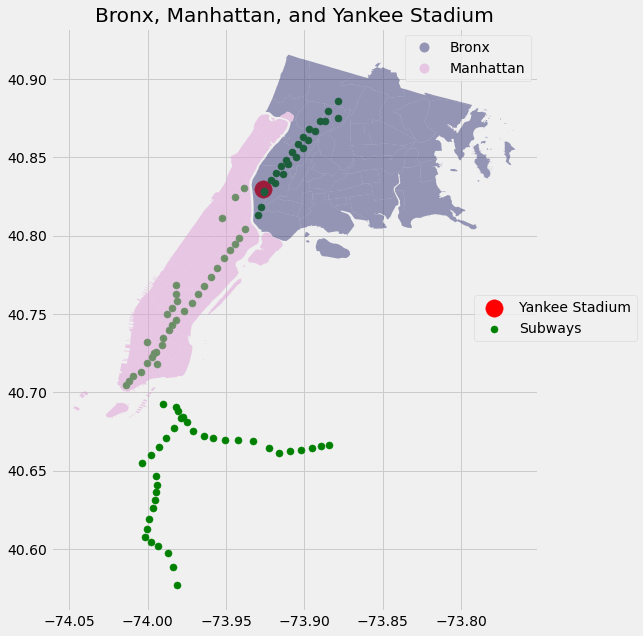

In [68]:
#Plot the count by borough into a map
fig,ax = plt.subplots(1,1, figsize=(10,10))

yankee_stadium.plot(markersize=300,color='red',ax=ax, label='Yankee Stadium')

subways.plot(markersize=50, color='green',ax=ax, label='Subways')

man_bronx_geo.plot(column='BoroName', cmap = 'tab20b',alpha=.5, ax=ax, legend=True)

plt.title("Bronx, Manhattan, and Yankee Stadium")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

In [69]:
#2 miles in feet is .001 * 32.195122 
yankee_stadium.crs = {'init' :'epsg:2263'}
stadium_buff = yankee_stadium.buffer(.001 * 32.195122)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [70]:
stadium_buff = gpd.GeoDataFrame({'geometry': stadium_buff})

In [71]:
stadium_buff

geometry
0  POLYGON ((-73.89399 40.82966, -73.89415 40.826...

In [72]:
stadium_buff.crs = {'init' :'epsg:2263'}
data.crs = {'init' :'epsg:2263'}

/home/ubuntu/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [73]:
airbnbs_within_2m_of_ys = gpd.sjoin(data,stadium_buff, how='inner', op='intersects')

In [74]:
len(airbnbs_within_2m_of_ys)

3540

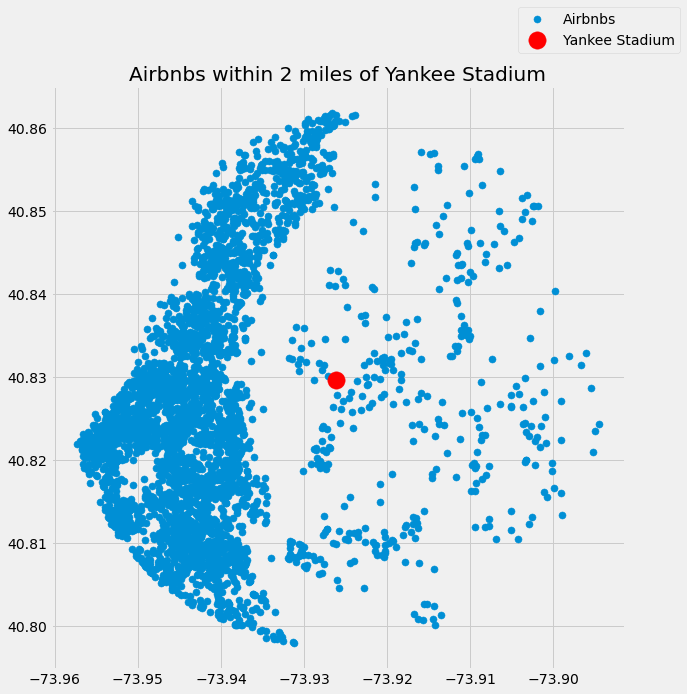

In [75]:
#Plot the airbnbs within 2 miles of Yankee stadium
fig,ax = plt.subplots(1,1, figsize=(10,10))
airbnbs_within_2m_of_ys.plot(markersize=50,ax=ax, label="Airbnbs")
yankee_stadium.plot(markersize=300,color='red',ax=ax, label="Yankee Stadium")
#man_bronx_geo.plot(column='BoroName', cmap = 'tab20b',alpha=.5, ax=ax, legend=True)
plt.title("Airbnbs within 2 miles of Yankee Stadium")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

### We now have all airbnbs within 2 miles of Yankee Stadium
##### We should now select all airbnbs that meet our other crtieria
 <a id="criteria"></a>


In [76]:
#Lets add our crieria, one by one, and see how many listings are left after each
print("Starting number of airbnbs: {0}".format(len(airbnbs_within_2m_of_ys)))

airbnbs_within_2m_of_ys = airbnbs_within_2m_of_ys.loc[airbnbs_within_2m_of_ys['price'] < 250]
print("Number of airbnbs after cutting price to less than $250: {0} ".format(len(airbnbs_within_2m_of_ys)))

airbnbs_within_2m_of_ys = airbnbs_within_2m_of_ys.loc[airbnbs_within_2m_of_ys['availability_365'] > 240]
print("Number of airbnbs after selecting those that are available at least 6 months out of the year: {0} ".format(len(airbnbs_within_2m_of_ys)))

airbnbs_within_2m_of_ys = airbnbs_within_2m_of_ys.loc[airbnbs_within_2m_of_ys['number_of_reviews'] >= 10]
print("Number of airbnbs after selecting those with at least 10 reviews: {0} ".format(len(airbnbs_within_2m_of_ys)))

airbnbs_within_2m_of_ys = airbnbs_within_2m_of_ys.loc[airbnbs_within_2m_of_ys['room_type'] == 'Entire home/apt']
print("Number of airbnbs after selecting those that offer the entire home/apt: {0} ".format(len(airbnbs_within_2m_of_ys)))

airbnbs_within_2m_of_ys = airbnbs_within_2m_of_ys.loc[airbnbs_within_2m_of_ys['minimum_nights'] <= 3]
print("Number of airbnbs left after selecting airbnbs that have a minimum night stay of 3 or less: {0} ".format(len(airbnbs_within_2m_of_ys)))

Starting number of airbnbs: 3540
Number of airbnbs after cutting price to less than $250: 3384 
Number of airbnbs after selecting those that are available at least 6 months out of the year: 711 
Number of airbnbs after selecting those with at least 10 reviews: 398 
Number of airbnbs after selecting those that offer the entire home/apt: 129 
Number of airbnbs left after selecting airbnbs that have a minimum night stay of 3 or less: 91 


In [77]:
airbnbs_within_2m_of_ys.head()

id                                    name  host_id host_name  \
120    27644                   Sugar Hill Rest Stop    119510      Emma   
206    54544      City Room - Private Penthouse Apt.   256161     Wayne   
401   128975             City Room - Street View Apt   256161     Wayne   
1705  772679        Very large, clean 1 BR apartment  4076876   Tauheed   
1738  786685  Big Brnstn Grdn Apt 2 stops to Midtown  4147380    Lauren   

       boroname neighbourhood  latitude  longitude        room_type  price  \
120   Manhattan        Harlem  40.82754  -73.94919  Entire home/apt    170   
206   Manhattan        Harlem  40.81035  -73.94598  Entire home/apt    121   
401   Manhattan        Harlem  40.81333  -73.94453  Entire home/apt    122   
1705  Manhattan   East Harlem  40.80343  -73.93514  Entire home/apt    120   
1738  Manhattan        Harlem  40.82294  -73.94999  Entire home/apt    225   

      minimum_nights  number_of_reviews last_review  reviews_per_month  \
120                2                195  2019-07-01               2.03   
206                1                104  2019-06-22               1.00   
401                1                116  2019-06-13               1.18   
1705               3                 22  2019-07-02               0.31   
1738               1                 50  2019-06-14               0.72   

      calculated_host_listings_count  availability_365  \
120                                1               318   
206                                5               247   
401                                5               271   
1705                               1               365   
1738                               1               265   

                        geometry  index_right  
120   POINT (-73.94919 40.82754)            0  
206   POINT (-73.94598 40.81035)            0  
401   POINT (-73.94453 40.81333)            0  
1705  POINT (-73.93514 40.80343)            0  
1738  POINT (-73.94999 40.82294)            0

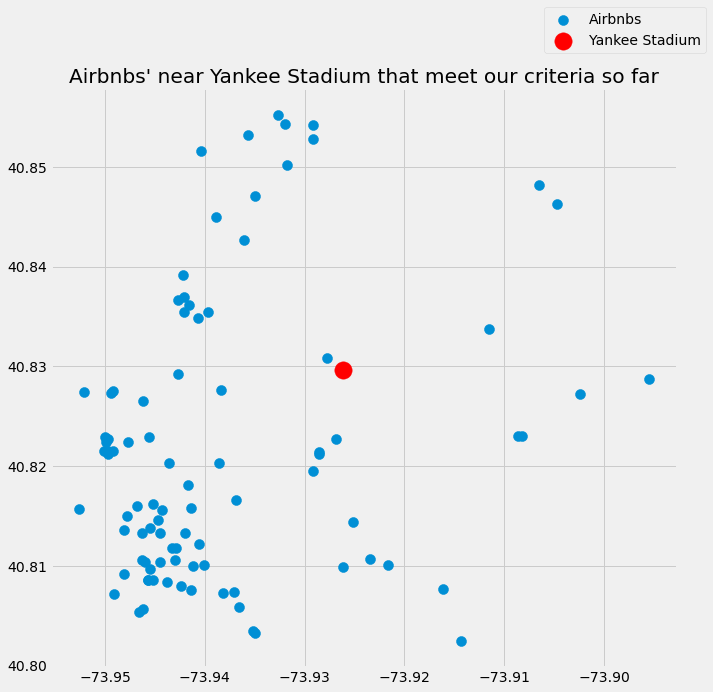

In [78]:
#Plot the airbnbs within 2 miles of Yankee stadium
fig,ax = plt.subplots(1,1, figsize=(10,10))
airbnbs_within_2m_of_ys.plot(markersize=100,ax=ax, legend=True, label="Airbnbs")
yankee_stadium.plot(markersize=300,color='red',ax=ax, label="Yankee Stadium")
plt.title("Airbnbs' near Yankee Stadium that meet our criteria so far")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

### We now need to verify airbnbs within 1/4 mile of subway stations that serve the D or 4 lines
# <a id="abnearsubways"></a>

In [79]:
#1/4 mile in feet is .001 * 3.657 
subways.crs = {'init' :'epsg:2263'}
subways_buff = subways.buffer(.001 * 3.657)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [80]:
#Create a geodataframe for the subways buffer. Set the crs to 2263
subways_buff = gpd.GeoDataFrame({'geometry': subways_buff})
subways_buff.crs = {'init' :'epsg:2263'}

In [81]:
#Rename the index_right column. It can not be in our final spatial join
airbnbs_within_2m_of_ys = airbnbs_within_2m_of_ys.rename(columns={'index_right': 'other_name'})

# Final Results
##### Here we will do our final analysis. We will identify the airbnbs that meet all of our conditions
 <a id="finalresults"></a>

In [82]:
#Lets find the airbnbs that intersect our subway buffers
final_abs = gpd.sjoin(airbnbs_within_2m_of_ys,subways_buff, how='inner', op='intersects')

In [83]:
#How many airbnbs meet all of our conditions?
print("There are {0} airbnbs that meet all of the conditions".format(len(final_abs)))

There are 13 airbnbs that meet all of the conditions


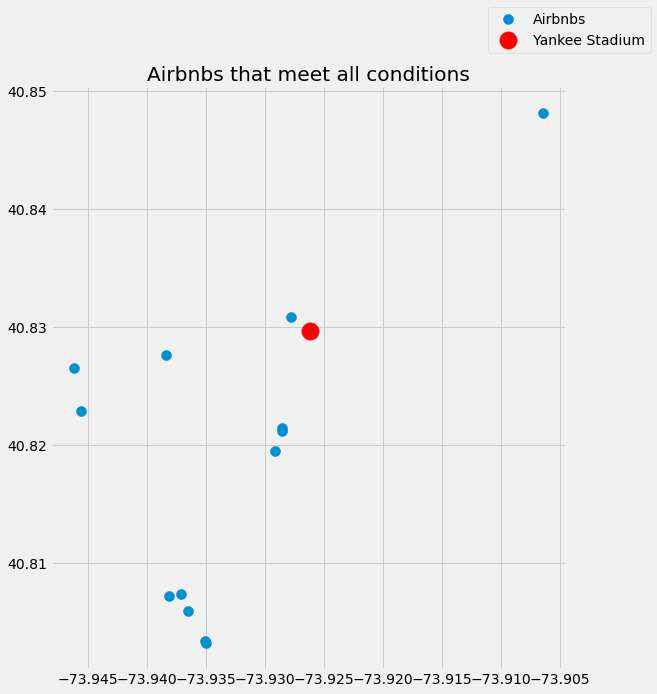

In [84]:
#Plot the final results
fig,ax = plt.subplots(1,1, figsize=(10,10))
final_abs.plot(markersize=100,ax=ax, label="Airbnbs")
yankee_stadium.plot(markersize=300,color='red',ax=ax, label="Yankee Stadium")

plt.title("Airbnbs that meet all conditions")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

In [85]:
#Lets look at the final results
final_abs

id                                               name    host_id  \
1705     772679                   Very large, clean 1 BR apartment    4076876   
5212    3766770                Romantic 1 bedroom Part2 Harlem USA   17479416   
18114  14178226     New Building Spacious 2 bed 2 bath  E. Harlem!   55229297   
22132  17812919     Vibrant Brownstone Penthouse Near Central Park    6430476   
37899  29981890                  MODERN & STYLISH HARLEM APARTMENT  224954032   
1996     880256                   Beautiful Trendy 2br Harlem Apt.    4655169   
5294    3827311                 Cozy & Sunny Hamilton Heights Apt    19693124   
11967   9328578   Sleeps 5, 2.5 bedrooms. Families or small group.   43963802   
8091    6244089                    Modern 3BR Brownstone Apartment   17264040   
16869  13436258                One Bedroom Apartment  in TownHouse    5944946   
34074  26996408                                Multicultural House  203123161   
35581  28250448                  Confortable apt in the Bronx NYC.   14214034   
31888  24886110  Spacious Apartment Steps Away from Yankee Stadium    6762900   

       host_name   boroname neighbourhood  latitude  longitude  \
1705     Tauheed  Manhattan   East Harlem  40.80343  -73.93514   
5212         Tae  Manhattan   East Harlem  40.80592  -73.93653   
18114     Amanda  Manhattan   East Harlem  40.80326  -73.93500   
22132       John  Manhattan   East Harlem  40.80726  -73.93815   
37899  Christina  Manhattan   East Harlem  40.80740  -73.93711   
1996    Rochelle  Manhattan        Harlem  40.82764  -73.93842   
5294        Maia  Manhattan        Harlem  40.82654  -73.94620   
11967      Tanya  Manhattan        Harlem  40.82287  -73.94561   
8091      Junior      Bronx    Mount Hope  40.84819  -73.90648   
16869     Nicole      Bronx     Concourse  40.81949  -73.92913   
34074       Luis      Bronx     Concourse  40.82120  -73.92859   
35581     Desmar      Bronx     Concourse  40.82145  -73.92856   
31888     Ashley      Bronx    Highbridge  40.83088  -73.92779   

             room_type  price  minimum_nights  number_of_reviews last_review  \
1705   Entire home/apt    120               3                 22  2019-07-02   
5212   Entire home/apt    150               3                 72  2019-04-29   
18114  Entire home/apt    215               1                 49  2019-06-19   
22132  Entire home/apt    177               2                130  2019-07-05   
37899  Entire home/apt    180               1                 17  2019-07-02   
1996   Entire home/apt    165               2                 21  2019-01-02   
5294   Entire home/apt    125               1                 10  2019-06-12   
11967  Entire home/apt    230               3                 52  2019-06-04   
8091   Entire home/apt    125               2                 41  2019-05-19   
16869  Entire home/apt     99               1                103  2019-06-18   
34074  Entire home/apt     80               3                 40  2019-06-23   
35581  Entire home/apt    102               2                 24  2019-06-26   
31888  Entire home/apt    103               2                 40  2019-06-30   

       reviews_per_month  calculated_host_listings_count  availability_365  \
1705                0.31                               1               365   
5212                1.23                               2               283   
18114               1.42                               1               316   
22132               4.80                               1               267   
37899               2.38                               1               334   
1996                0.30                               1               347   
5294                0.17                               1               297   
11967               1.33                               2               325   
8091                0.81                               2               342   
16869               2.87                            

<h1 align="center"> The End!</h1>

 <h2 align="center"> Thank you for exploring this notebook </h2> 

